In [4]:
!pip install torch torchvision pillow matplotlib


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
def load_image(img_path, max_size=400):
    image = Image.open(img_path).convert("RGB")
    size = max(image.size)
    scale = max_size / size
    transform = transforms.Compose([
        transforms.Resize((int(image.size[1]*scale), int(image.size[0]*scale))),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

content = load_image("tajmahal.jpg")
style = load_image("style.jpg")


In [8]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:11<00:00, 47.9MB/s]


In [9]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [10]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [19]:
with torch.no_grad():
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [20]:
target = content.clone().requires_grad_(True).to(device)


In [21]:
optimizer = optim.Adam([target], lr=0.003)

style_weight = 1e6
content_weight = 1


In [22]:
steps = 200

for step in range(steps):
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        style_loss += torch.mean((target_gram - style_gram)**2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Total loss: {total_loss.item():.4f}")


Step 0, Total loss: 27330493808640.0000
Step 50, Total loss: 3293872652288.0000
Step 100, Total loss: 1922359623680.0000
Step 150, Total loss: 1372387147776.0000


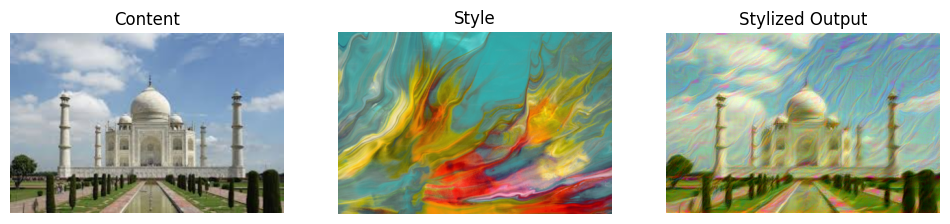

In [23]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach()
    image = image.squeeze()
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
imshow(content, "Content")

plt.subplot(1,3,2)
imshow(style, "Style")

plt.subplot(1,3,3)
imshow(target, "Stylized Output")

plt.show()
